Using mobilenet image classification, pretrained model, on the other not-known classes for the model. First training and then predictions.

**Fine tuning and using mobile net model for predicting the cat and dog classes.**

 i want fine tune this mobile net model for my dataset. My dataset is composed of only two classes cats and dogs. As per theory, take everythong from this model, except the output layer, then complete it for my output layer. Then freez its 50% layers and train the model on remaining all the layers. Please do this

 Certainly! Let's fine-tune the MobileNet model for your dataset, which consists of two classes: cats and dogs. We'll follow these steps:

1. **Load the Pre-trained MobileNet Model:**
   - Use the MobileNet model pre-trained on a large dataset (ImageNet).

2. **Remove the Top Layers:**
   - Remove the top layers of the MobileNet model, including the output layer.
   
   (When we say "remove the top layers," we are typically referring to removing the final layers of the pre-trained model, including the output layer. In the case of the MobileNet model, these top layers consist of the global average pooling layer and the dense output layer)

3. **Add Custom Output Layer:**
   - Add a new output layer with two units (for cats and dogs) and a softmax activation function.

4. **Freeze Some Layers:**
   - Freeze 50% of the layers in the model.

5. **Compile the Model:**
   - Compile the model with an appropriate optimizer, loss function, and metrics.

6. **Train the Model:**
   - Train the model on your dataset.

Let's implement this:

```python
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Remove top layers
x = base_model.output

# Add custom output layer
x = GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='softmax')(x)  # 2 units for cats and dogs

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze 50% of the layers
for layer in model.layers[:len(model.layers)//2]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()
```

Now, assuming you have your dataset organized into train, validation, and test sets in separate directories (`train`, `valid`, and `test`), you can proceed with the data generators and training:

```python
# Set the paths to your dataset
train_path = "/path/to/your/dataset/train"
valid_path = "/path/to/your/dataset/valid"
test_path = "/path/to/your/dataset/test"

# Create data generators
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=32, shuffle=False)

# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
```

Make sure to replace `"/path/to/your/dataset"` with the actual path to your dataset. This code assumes that your dataset is organized into folders for training, validation, and testing, with each class in a separate subfolder.

Feel free to adjust parameters such as batch size, learning rate, and the number of epochs based on your specific requirements.

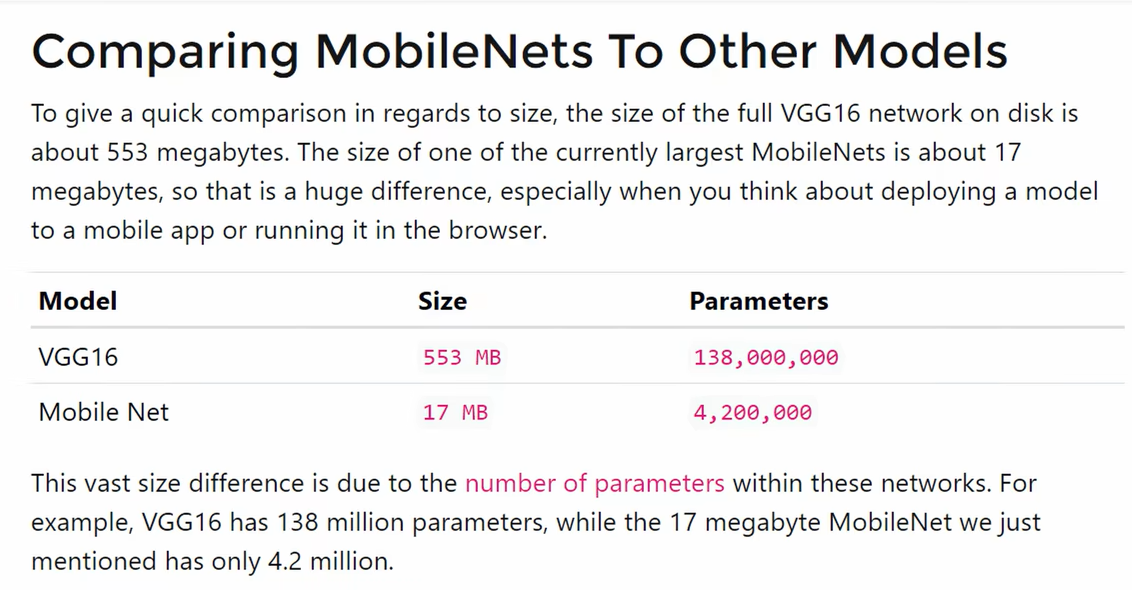

Relatively small accuracy difference. Accuracy trade-off. But very less difference in accuracies of vgg16 and mobile net models.

In [1]:
import numpy as np  # Importing NumPy for numerical operations and array handling.
import tensorflow as tf  # Importing TensorFlow, a machine learning framework.
from tensorflow import keras  # Importing Keras, an API for building neural networks.
from tensorflow.keras.layers import Dense, Activation  # Importing specific layers for the neural network.
from tensorflow.keras.optimizers import Adam  # Importing the Adam optimizer for model optimization.
from tensorflow.keras.metrics import categorical_crossentropy  # Importing categorical cross-entropy metric.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing image data augmentation tools.
from tensorflow.keras.preprocessing import image  # Importing image preprocessing utilities.
from tensorflow.keras.models import Model  # Importing Keras Model for creating neural network models.
from tensorflow.keras.applications import imagenet_utils  # Importing ImageNet-specific utilities.
from sklearn.metrics import confusion_matrix  # Importing confusion matrix for model evaluation.
import itertools  # Importing itertools for iterating tools.
import os  # Importing os module for interacting with the operating system.
import shutil  # Importing shutil for high-level file operations.
import random  # Importing random for generating random numbers or choices.
import matplotlib.pyplot as plt  # Importing matplotlib for data visualization.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    print("Num of GPUs Available:", len(physical_devices))
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU devices available. Or if working on google colab, need to change runtime type to t4-gpu to access gpu")


Num of GPUs Available: 1


In [3]:
tf.config.experimental.list_physical_devices()  # () me 'CPU' or 'GPU' both can be written, but we are interested in gpu, hence were writting 'GPU', not the 'CPU'

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [6]:
def prepare_image(file):
  img_path = '/content/'
  img = image.load_img(img_path + file, target_size=(224,224)) # mobile net expect 224, 224 size
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims) # in real, this function(preprocess) is doing pixel values [-1,1] using mean and standad deviation from [0, 255]

# overall entire function =
# 1. reshaping input image to (224,224), [224,224] size now
# 2. converting image to array of 3 dim(r,g,b), [3,224,224] size now : channels separated
# 3. adds an extra dim = 4D imgae now, just [1,3,224,224] size now
# 4. in all the three channels, pixel values ko [-1,1] krna from original [0,255]

No problem! The corrected code you provided is for preparing an image for a MobileNet model. Let's break down the function with the corrected import:

```python
def prepare_image(file):
    # Specify the path where the image file is located
    img_path = '/content/'

    # Load the image from the specified path and resize it to (224, 224) pixels
    img = image.load_img(img_path + file, target_size=(224, 224))

    # Convert the image to a NumPy array (image.img_to_array)
    img_array = image.img_to_array(img)

    # Add an extra dimension to the array to match the expected input shape for the model
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)

    # Preprocess the image array using the preprocess_input function of MobileNet
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
```

Explanation (similar to the previous explanation with the corrected import):

1. **Function Signature:**
   - `def prepare_image(file):`: This function takes a filename (`file`) as an argument.

2. **Image Path:**
   - `img_path = '/content/'`: Specifies the directory path where the image file is located. You may need to adjust this path based on your actual directory structure.

3. **Load and Resize Image:**
   - `img = image.load_img(img_path + file, target_size=(224, 224))`: Uses the Keras `image` module to load an image from the specified path (`img_path + file`) and resizes it to (224, 224) pixels.

4. **Convert to NumPy Array:**
   - `img_array = image.img_to_array(img)`: Converts the image to a NumPy array. This array will represent the pixel values of the image.

5. **Expand Dimensions:**
   - `img_array_expanded_dims = np.expand_dims(img_array, axis=0)`: Adds an extra dimension to the array. This is done to match the expected input shape for many deep learning models, which often expect batches of images as input.

6. **Preprocess Image for MobileNet:**
   - `return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)`: Applies preprocessing specific to the MobileNet model using the `preprocess_input` function from the MobileNet module. This preprocessing step is important to ensure that the input to the MobileNet model is in the correct format and scale.

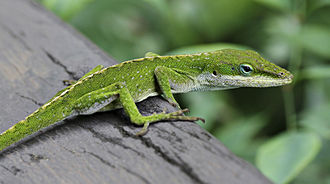

In [7]:
# Displaying our first image : 1_american_chameleon(Girgit in hindi).png : downloaded from google
from IPython.display import Image
Image(filename='/content/1_american_chameleon.jpg',width=300, height=200) # these width and height = jisme hme show krna hai image ko vo hain

In [8]:
# predicting it using the raw loaded mobilenet model
preprocessed_image = prepare_image('1_american_chameleon.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions) # top 5 pobability class will be printed
results

35363/35363 [==============================] - 0s 0us/step


[[('n01682714', 'American_chameleon', 0.7912197),
  ('n01693334', 'green_lizard', 0.20535393),
  ('n01689811', 'alligator_lizard', 0.0013780014),
  ('n01685808', 'whiptail', 0.001367064),
  ('n01687978', 'agama', 0.0003363772)]]

In [9]:
assert results[0][0][1]=='American_chameleon' # no error => correct prediction

In [10]:
# first 0 = for 1st image, suppose 1 se jyada images hoti batch me tb, number or rows in result 2D array = number of imput images. Here input image only 1 hai do results array me only 1 row hai
# second 0 = for selected row/image number me 1st class ko pick kro. As result array ki each different row me output for each different image hai. Now each row ke andar = for that particular image, top 5 predicted clsses as a tuple store hain. So each row is of size 5 elements, but ye sbhi 5 elements actual me 5 tuples(each of 3 elements) hain
# now as each of the 5 element is a tuple, so [0][0][0] will represent the first element of the first tuple i.e. n01682714
# each tuple is of the form (class_label, class_description, probability).
results[0] # one full row for the first image predicted classes will be printed

[('n01682714', 'American_chameleon', 0.7912197),
 ('n01693334', 'green_lizard', 0.20535393),
 ('n01689811', 'alligator_lizard', 0.0013780014),
 ('n01685808', 'whiptail', 0.001367064),
 ('n01687978', 'agama', 0.0003363772)]

In [11]:
results[0][1] # 1st row me 2nd index vala tuple will be printed, i.e. first image ki 2nd highest most probable class

('n01693334', 'green_lizard', 0.20535393)

In [12]:
results[0][1][1] # now this is accessing in the tuple. tuple ka 1st index = class_discription hai

'green_lizard'

1. More formal description of results array by chat gpt

Certainly, let's formalize the explanation:

```plaintext
# Explanation of Indexing in the Results 2D Array:

- The first index (results[0]) represents the row corresponding to the first image in the batch.
- The second index (results[0][1]) selects the tuple at the second index within the row.
- The third index (results[0][1][1]) accesses the class description within the selected tuple.

# Interpretation:

1. `results[0]`: Represents the full row of predicted classes for the first image.
   - Each element in this row is a tuple containing (class_label, class_description, probability).

2. `results[0][1]`: Represents the tuple at the second index within the row for the first image.
   - This tuple contains information about the second highest most probable class for the first image.

3. `results[0][1][1]`: Represents the class description within the tuple for the second highest most probable class.
   - This value corresponds to the textual description of the class.

# Overall:
- The indexing hierarchy allows you to navigate through the results array to retrieve specific information about the predicted classes for each image in the batch.
- It is important to note that the indexing is zero-based, and each element in the array is a tuple with three components: class_label, class_description, and probability.
```

This formalizes the explanation, providing a step-by-step guide to understanding the structure and indexing of the `results` array.

2. More formal description by chat gpt

Absolutely! Here's a more formal explanation of accessing and understanding the `results` 2D array generated from the `decode_predictions` function:

```python
# Given results is a 2D array from decode_predictions
# First dimension represents different images in the input or batch

# Accessing rows (images) and elements within rows (predictions)
results[0]  # Accesses the predictions for the first image in the input
results[1]  # Accesses the predictions for the second image in the input (if available)

# Accessing elements within rows (predictions for a specific image)
results[0][0]  # Accesses the first (most probable) prediction for the first image
results[0][1]  # Accesses the second prediction for the first image
results[0][2]  # Accesses the third prediction for the first image
results[0][3]  # Accesses the fourth prediction for the first image
results[0][4]  # Accesses the fifth prediction for the first image

# Accessing components (class label, description, probability) within a prediction tuple
results[0][0][0]  # Accesses the class label of the most probable prediction for the first image
results[0][0][1]  # Accesses the class description of the most probable prediction for the first image
results[0][0][2]  # Accesses the probability of the most probable prediction for the first image

results[0][1][0]  # Accesses the class label of the second most probable prediction for the first image
results[0][1][1]  # Accesses the class description of the second most probable prediction for the first image
results[0][1][2]  # Accesses the probability of the second most probable prediction for the first image

# Example explanations:
# `results[0][1][1]` represents the class description of the second most probable prediction for the first image.
# `results[1][2][2]` would represent the probability of the third most probable prediction for the second image.
```

This explanation breaks down how to navigate the `results` array to access predictions for different images, predictions for a specific image, and components within each prediction tuple (class label, description, probability).

In [13]:
# for another image: doing everything but without nay comments

# showing the image
from IPython.display import Image
Image(filename='/content/2_strawberry.jpg',width=300, height=200)

# predicting most probable top 5 classes using the raw loaded mobilenet model
preprocessed_image = prepare_image('2_strawberry.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions) # top 5 pobability class will be printed
print(results) # printing the prediction result

# prediction varification ki sahi hai ya nhi
assert results[0][0][1]=='strawberry'

1/1 [==============================] - 0s 19ms/step
[[('n07745940', 'strawberry', 0.99577206), ('n04423845', 'thimble', 0.0013203596), ('n02948072', 'candle', 0.0002690613), ('n07742313', 'Granny_Smith', 0.00023865217), ('n04332243', 'strainer', 0.00022567203)]]


wow such a great prediction ki 99% ye strawberry hai.

Let's predict for a batch of two images. Need to change preprocessing function in that case. Just to see the 2nd row in the results array.

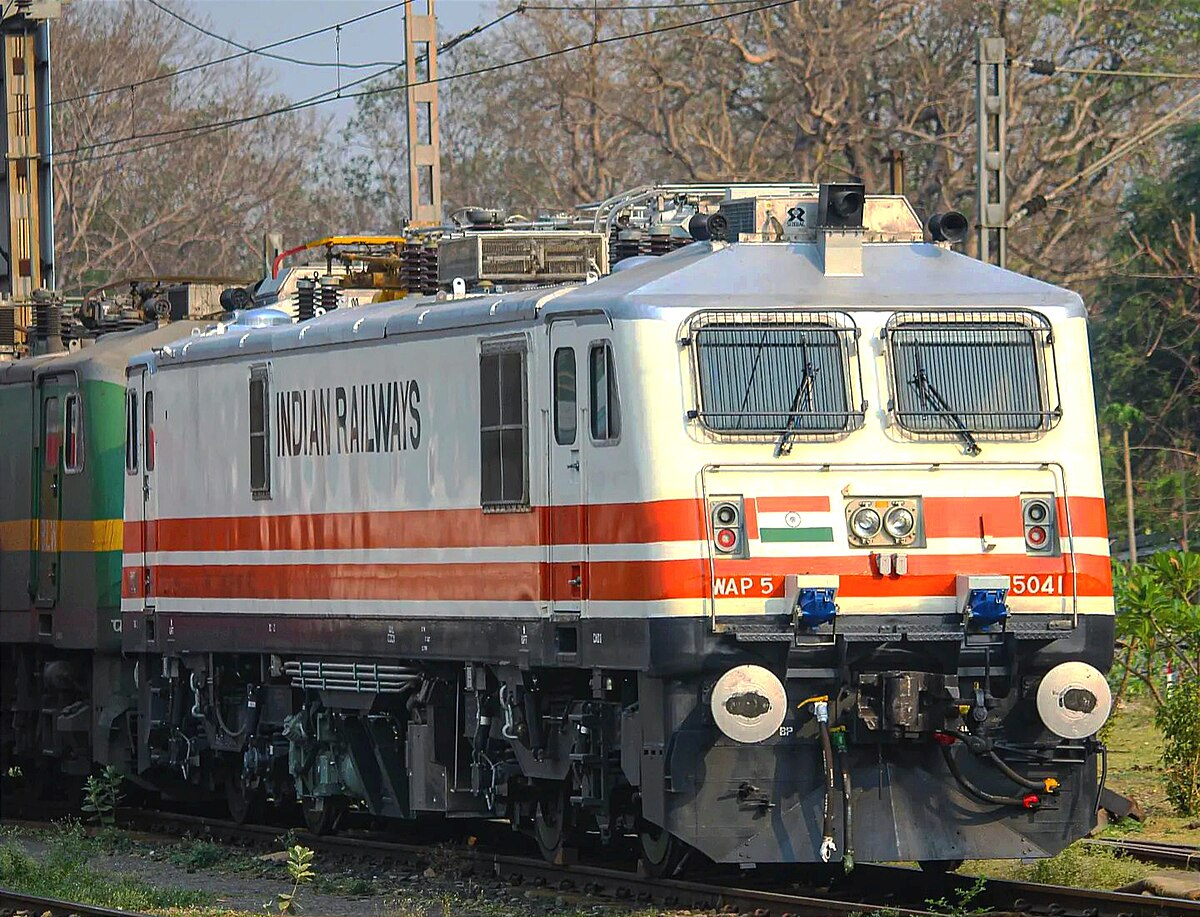

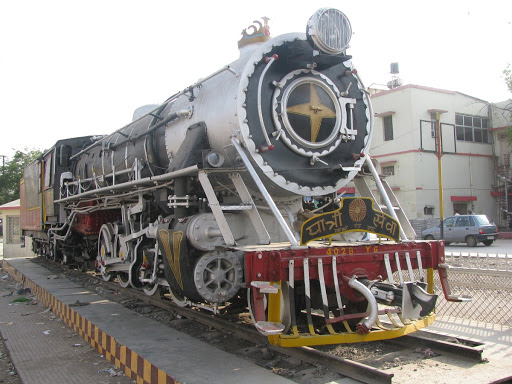

1/1 [==============================] - 0s 459ms/step


[[('n03272562', 'electric_locomotive', 0.9998987),
  ('n03895866', 'passenger_car', 7.126977e-05),
  ('n04310018', 'steam_locomotive', 2.3038694e-05),
  ('n03393912', 'freight_car', 5.919456e-06),
  ('n04335435', 'streetcar', 5.478751e-07)],
 [('n04310018', 'steam_locomotive', 0.9998031),
  ('n03393912', 'freight_car', 8.132815e-05),
  ('n03272562', 'electric_locomotive', 6.3220985e-05),
  ('n03345487', 'fire_engine', 1.9176126e-05),
  ('n03895866', 'passenger_car', 1.0949677e-05)]]

In [14]:
# electrical and steam locomotive prediction : as a railfan, what else can be better than this. Both the class labels were there in the mobilenet classlist
def prepare_images(files):
    img_path = '/content/'
    img_list = [] # to store the predicted set of claaases of each input images

    for file in files:
        img = image.load_img(img_path + file, target_size=(224, 224)) #1. 224*224 banaya
        img_array = image.img_to_array(img) # 2. img to array of 3 dim i.e. 3d array of 3 2d arrays/channels(r,g,b)
        img_array_expanded_dims = np.expand_dims(img_array, axis=0) # each image ko 4d kr diya, Predictions abhi bhi one batch size ki image se kr rhe hain, hence preprocessing steps are same. Just for loop of each of the images badh gya
        img_list.append(tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims))

    return np.vstack(img_list) # np.vstack takes a tuple of arrays (array1, array2) and vertically stacks them, yhan puri list me jo bhi arrays hain, sb ko stack kr dega

# Showing the images
from IPython.display import Image, display
display(Image(filename='/content/ele_loco.jpg', width=300, height=200))
display(Image(filename='/content/steam_loco.jpg', width=300, height=200))

# Predicting most probable top 5 classes using the raw loaded MobileNet model
preprocessed_images = prepare_images(['ele_loco.jpg', 'steam_loco.jpg'])
predictions = mobile.predict(preprocessed_images)
results = imagenet_utils.decode_predictions(predictions)

# Printing the prediction results
results  # alternate : print(results) but better feel nhi aayegi us trh se.
# now result array 2D hai, ki feel aa gyi. TY


Good, great prediction. 99% electric loco for the first image, and 99% steam_loco for the second image.

* Now fine tuning the loaded mobile net model to do predictions for the classes that were not already present in the mobile net training process. : transfer learning.



- Fine-tuning a pre-trained model, such as MobileNet, for a specific task is a form of transfer learning. Transfer learning involves taking a model trained on a large dataset for a general task and adapting it for a different, often more specific, task. The idea is to leverage the knowledge gained during the training on the large dataset to improve performance on the target task, even when the target dataset is relatively small.

- Here's a high-level overview of the steps involved in fine-tuning a MobileNet model for a new set of classes:

1. **Load the Pre-trained MobileNet Model:**
   - Use the MobileNet model pre-trained on a large dataset (e.g., ImageNet).

2. **Add Custom Top Layers:**
   - Add new layers on top of the pre-trained MobileNet base to adapt it to the target task.
   - Adjust the number of units in the last Dense layer to match the number of classes in your target task.


3. **Freeze Base Layers (Optional):**
   - Optionally, you can choose to freeze some or all of the layers in the pre-trained base to prevent them from being updated during training.


4. **Compile the Model:**
   - Compile the model with an appropriate optimizer, loss function, and metrics for your task.


5. **Train the Model:**
   - Train the model on your target dataset.

6. **Evaluate and Fine-Tune:**
   - Evaluate the model on a validation set, and fine-tune hyperparameters if needed.

This process allows the model to adapt its knowledge to the specific classes and characteristics of your target task. Keep in mind that the number of classes in your output layer (`NUM_CLASSES`) should match the number of classes in your target task. Additionally, ensure that your input data is preprocessed using the appropriate method (e.g., `preprocess_input` from MobileNet).

**Working with dataset that will be completely different from dataset in imagenet.** SIGN LANGUAGE DIGITS : kaggle pr as a grayscale images, and github pr rgb images ke fom me available hai. We will be using rgb images.

In [15]:
import os
import shutil
import random

# Set the absolute path to the dataset directory
dataset_path = '/content/drive/MyDrive/Dataset'

# Change the working directory to the dataset directory
os.chdir(dataset_path)

# Check and create train, valid, and test directories if they don't exist
if not os.path.isdir('train/0'):
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    # Organize data into train, valid, and test directories for each class
    for i in range(10):
        shutil.move(f'{i}', 'train') # initially move all directories to train directory
        os.mkdir(f'valid/{i}') # make valid and test as well.
        os.mkdir(f'test/{i}')

        # Randomly select samples for validation
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30) # 30 randomly selected samples from {i}, that file is there in valid_sample as well as in {i}.
        for j in valid_samples: # j is a file inside {i} directory(also in valid_sample). : {i} directory me se {j} file ko uthakar valid me dal do
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        # Randomly select samples for testing
        test_samples = random.sample(os.listdir(f'train/{i}'), 5) # 5 randomly selected samples from  remaining files in {i}.
        for k in test_samples:  # for each elements in 5 randomly selected files list, un sabhi 5 files ko train/{i} directory se uthakar test/{i} directory me dal do, wrt pwd.
            shutil.move(f'train/{i}/{k}', f'test/{i}')

# Correct the working directory back to the original location
os.chdir('/content')


Certainly! Let's go through the code line by line to understand each step:

```python
import os
import shutil
import random
```

1. **Importing Modules:**
   - `import os`: Imports the `os` module, which provides a way to interact with the operating system.
   - `import shutil`: Imports the `shutil` module, which offers a higher-level interface for file operations.
   - `import random`: Imports the `random` module, used for random sampling.

```python
# Set the absolute path to the dataset directory
dataset_path = '/content/drive/MyDrive/Dataset'
```

2. **Setting Dataset Path:**
   - `dataset_path = '/content/drive/MyDrive/Dataset'`: Sets the absolute path to the dataset directory. Assumes the dataset is located at this path.

```python
# Change the working directory to the dataset directory
os.chdir(dataset_path)
```

3. **Changing Working Directory:**
   - `os.chdir(dataset_path)`: Changes the current working directory to the dataset directory specified in `dataset_path`.

```python
# Check and create train, valid, and test directories if they don't exist
if not os.path.isdir('train/0'):
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
```

4. **Check and Create Directories:**
   - `if not os.path.isdir('train/0'):`: Checks if the directories `train/0` (assumes a class labeled '0') exist.
   - `os.mkdir('train')`: If not, creates the `train` directory.
   - `os.mkdir('valid')`: Creates the `valid` directory.
   - `os.mkdir('test')`: Creates the `test` directory.

```python
    # Organize data into train, valid, and test directories for each class
    for i in range(10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
```

5. **Organizing Data:**
   - `for i in range(10):`: Iterates over the classes (assumed to be labeled '0' to '9').
   - `shutil.move(f'{i}', 'train')`: Moves the entire class directory to the `train` directory.
   - `os.mkdir(f'valid/{i}')`: Creates a directory for validation samples for the current class.
   - `os.mkdir(f'test/{i}')`: Creates a directory for test samples for the current class.

```python
        # Randomly select samples for validation
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
```

6. **Selecting Validation Samples:**
   - `valid_samples = random.sample(os.listdir(f'train/{i}'), 30)`: Randomly selects 30 samples from the training set for validation.
   - `for j in valid_samples:`: Iterates over the selected validation samples.
   - `shutil.move(f'train/{i}/{j}', f'valid/{i}')`: Moves each selected sample to the validation directory for the corresponding class.

```python
        # Randomly select samples for testing
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
```

7. **Selecting Test Samples:**
   - `test_samples = random.sample(os.listdir(f'train/{i}'), 5)`: Randomly selects 5 samples from the remaining training set for testing.
   - `for k in test_samples:`: Iterates over the selected test samples.
   - `shutil.move(f'train/{i}/{k}', f'test/{i}')`: Moves each selected sample to the test directory for the corresponding class.

```python
# Correct the working directory back to the original location
os.chdir('/content')
```

8. **Changing Working Directory Back:**
   - `os.chdir('/content')`: Changes the current working directory back to the original location, assuming the original location is `/content`.

This code is organizing a dataset into train, validation, and test sets for each class, assuming a structure where each class is represented by a separate directory (labeled '0' to '9'). It uses `shutil.move` to move entire class directories, and `random.sample` to randomly select samples for validation and testing. The original working directory is then restored at the end.

**DATA PREPROCESSING**

In [16]:
train_path = "/content/drive/MyDrive/Dataset/train"
valid_path = "/content/drive/MyDrive/Dataset/valid"
test_path = "/content/drive/MyDrive/Dataset/test"

In [17]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [18]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

**MODIFY MODEL** : fine tuning mobilenet model for a custom dataset.

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNet model without the top (fully connected) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 50% of the base model layers
for layer in base_model.layers[:len(base_model.layers) * 9//10 ]:  # // = integer division : gint
    layer.trainable = False

# Add custom top layers for your classification task. remember mobilenet model is a functional model
# we will do such that the output tensor of the all mobile net layers will become the input tensor of the our output layer. Bs vhi hai kiya ja rha yhan, han global pooling etc layers bhi hain
x = base_model.output # stores the output tensor of mobile net layers
x = GlobalAveragePooling2D()(x) # perform global average pooling
x = Dropout(0.5)(x) # during the training half of the tensor will set to zero.
x = Dense(256, activation='relu')(x) # another fc layer with relu activation
predictions = Dense(10, activation='softmax')(x)  # Assuming you have 10 classes, prediction stores the output tensor

# Create the final model for fine-tuning
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

The double slash // is used for integer division in Python. When you use a single slash /, it performs floating-point division, and when you use //, it performs integer division (floor division).

In [24]:
len(model.layers)

90

In [25]:
# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
# remember train_labels are passed autometically in case input is passed by inputGenerator

Epoch 1/10
172/172 - 153s - loss: 1.2220 - accuracy: 0.6005 - val_loss: 0.5369 - val_accuracy: 0.8267 - 153s/epoch - 889ms/step
Epoch 2/10
172/172 - 7s - loss: 0.3958 - accuracy: 0.8803 - val_loss: 0.1322 - val_accuracy: 0.9733 - 7s/epoch - 40ms/step
Epoch 3/10
172/172 - 7s - loss: 0.2289 - accuracy: 0.9322 - val_loss: 0.1356 - val_accuracy: 0.9500 - 7s/epoch - 41ms/step
Epoch 4/10
172/172 - 6s - loss: 0.1546 - accuracy: 0.9556 - val_loss: 0.0698 - val_accuracy: 0.9833 - 6s/epoch - 35ms/step
Epoch 5/10
172/172 - 7s - loss: 0.1045 - accuracy: 0.9737 - val_loss: 0.0800 - val_accuracy: 0.9767 - 7s/epoch - 38ms/step
Epoch 6/10
172/172 - 7s - loss: 0.0875 - accuracy: 0.9761 - val_loss: 0.0780 - val_accuracy: 0.9667 - 7s/epoch - 39ms/step
Epoch 7/10
172/172 - 7s - loss: 0.0605 - accuracy: 0.9842 - val_loss: 0.0358 - val_accuracy: 0.9967 - 7s/epoch - 40ms/step
Epoch 8/10
172/172 - 6s - loss: 0.0582 - accuracy: 0.9836 - val_loss: 0.0317 - val_accuracy: 0.9933 - 6s/epoch - 36ms/step
Epoch 9/10


same accuracy in train and validation sets, so not overfitted.

**Predict Sign Language Digits**



In [26]:
test_labels = test_batches.classes

In [27]:
predictions = model.predict(x=test_batches, verbose=1)

5/5 [==============================] - 11s 3s/step


In [28]:
cm = confusion_matrix(y_true = test_labels, y_pred=predictions.argmax(axis=1))

In the code snippet you provided:

```python
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
```

`predictions` is likely the output of your model, representing the predicted probabilities for each class. The `argmax(axis=1)` part is used to obtain the class indices with the highest predicted probability along axis 1 (which corresponds to the classes). In other words, it returns the index of the maximum value for each prediction.

Here's a breakdown:

- `predictions` is an array where each row corresponds to a set of predicted probabilities for each class.
- `predictions.argmax(axis=1)` returns an array of indices, where each index represents the predicted class for the corresponding row in `predictions`.

This is commonly used when dealing with categorical predictions. The confusion matrix is then computed based on the true labels (`y_true`) and the predicted class indices (`y_pred`). The `confusion_matrix` function compares the true labels against the predicted class indices and counts the occurrences of each combination, forming the confusion matrix.

For example, if `predictions.argmax(axis=1)` gives `[0, 1, 0, 1, 1]`, it means the predicted classes are `[Class 0, Class 1, Class 0, Class 1, Class 1]`. The confusion matrix will then compare these predictions against the true labels (`y_true`).

In [29]:
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])

In [30]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

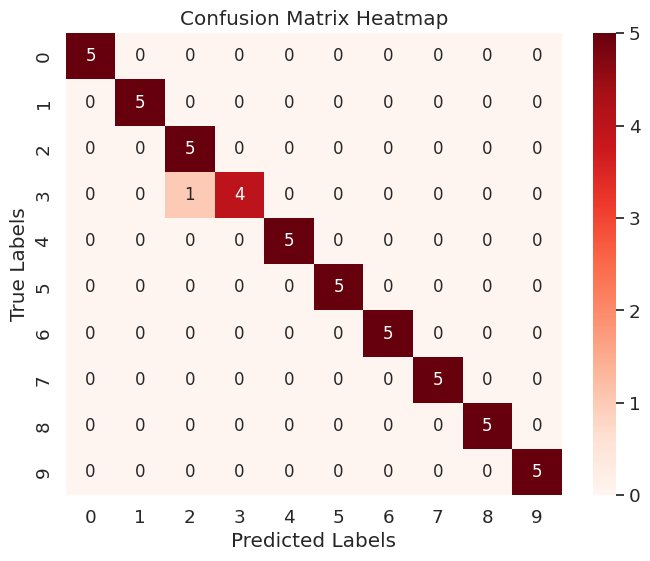

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a 2D array `cm` representing the confusion matrix
# For example:
# cm = [[10, 2],
#       [3,  15]]

# Create a heatmap
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 12})

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

Recall we had total 5-5 images of each classes.

Good about 99% accuracy on test data as 49/50 correct predictions. Ye hai transfer learning ka use.

**Deta Augumentation with TensorFlow Keras API.** ( on images)

DA = Creating new data by making modifications on the original data.

flipping, rotating, changing color of images etc.

Lot of time not having enough data. Do DA to get more data from the available data.

Data augmentation is a technique used to artificially increase the diversity of a training dataset by applying various transformations to the existing data. The goal is to create new variations of the input data that are still representative of the underlying patterns, thereby helping to improve the generalization and robustness of machine learning models. This technique is commonly used in computer vision tasks, such as image classification.

Here are some common data augmentation techniques:

1. **Rotation:** Rotating the image by a certain angle (e.g., 90 degrees, 180 degrees) to simulate variations in object orientation.

2. **Flip:** Flipping the image horizontally or vertically to account for variations in the position of objects.

3. **Zoom:** Zooming in or out of the image to simulate variations in scale.

4. **Translation:** Shifting the image horizontally or vertically to simulate changes in the position of objects within the frame.

5. **Shear:** Applying a shear transformation, which tilts the image along one axis, introducing deformations.

6. **Brightness and Contrast Adjustment:** Changing the brightness or contrast of the image to simulate variations in lighting conditions.

7. **Color Jittering:** Introducing small random changes to the color of the image, such as hue and saturation adjustments.

8. **Random Cropping:** Cropping a random part of the image to focus on different regions of interest.

By applying these transformations to the training data, the model is exposed to a more diverse set of examples, which can help it generalize better to unseen data. However, it's important to note that data augmentation is typically applied only to the training set and not to the validation or test sets, as the goal is to evaluate the model's performance on the original, unaltered data.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 10 columns,
# where images are placed side by side. The input to this function is a list of
# images (image_arr), and it will display them in a single row with 10 columns.

def plotImages(image_arr):
    # Create a figure with 1 row and 10 columns
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))

    # Flatten the 2D array of axes into a 1D array
    axes = axes.flatten()

    # Iterate through the images and corresponding axes
    for img, ax in zip(image_arr, axes):
        # Display the image on the current axis
        ax.imshow(img)

        # Turn off axis labels
        ax.axis('off')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()


In [36]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.15, zoom_range=0.1,
                         channel_shift_range=10, horizontal_flip= True)

In [37]:
chosen_image = '/content/ele_loco.jpg'

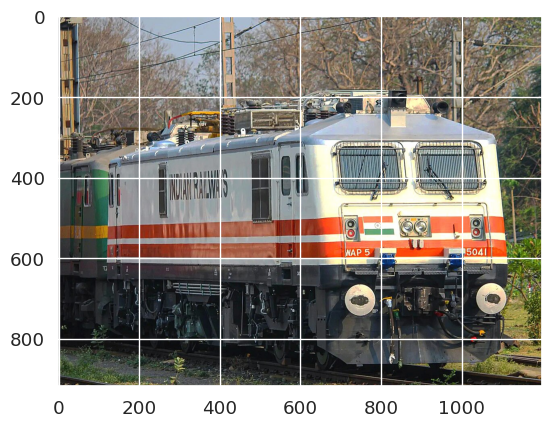

In [42]:
# obtain image
image = np.expand_dims(plt.imread(chosen_image),0)
plt.imshow(image[0])

In [43]:
# Generate batches of augmented images from this image
aug_iter = gen.flow(image)

In [48]:
# get 10 samples of the augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)] # set/list of 10 images

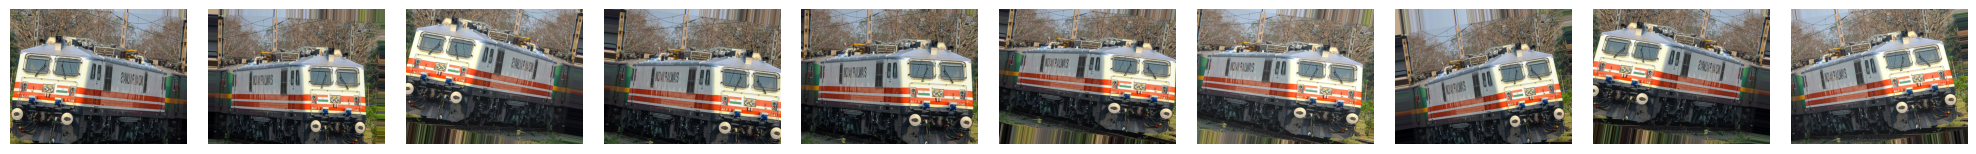

In [49]:
# Augmented Images
plotImages(aug_images)

Certainly, let's break down the code step by step:

```python
# Create an ImageDataGenerator object with specified augmentation parameters
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.15, zoom_range=0.1,
                         channel_shift_range=10, horizontal_flip=True)
```
- `ImageDataGenerator`: This is a class provided by Keras that generates batches of augmented images. It takes various augmentation parameters as arguments, such as rotation range, width shift range, height shift range, shear range, zoom range, channel shift range, and horizontal flip. These parameters define the types and degrees of augmentation to be applied to the images.

```python
# Path to the chosen image
chosen_image = '/content/ele_loco.jpg'

# Read and display the original image
image = np.expand_dims(plt.imread(chosen_image), 0)
plt.imshow(image[0])
```
- `chosen_image`: This is the path to the image that you want to augment.
- `plt.imread(chosen_image)`: This reads the image using Matplotlib's `imread` function.
- `np.expand_dims(...)`: It adds an extra dimension to the image array. This is required because the `flow` method of `ImageDataGenerator` expects a 4D array, where the first dimension represents the batch size.

```python
# Generate batches of augmented images from the original image
aug_iter = gen.flow(image)
```
- `gen.flow(image)`: This creates a generator that will yield batches of augmented images based on the original image and the augmentation parameters specified earlier.

```python
# Get 10 samples of the augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
```
- `next(aug_iter)`: This gets the next batch of augmented images from the generator.
- `next(aug_iter)[0]`: This extracts the augmented images from the batch. The `[0]` indexing is used to access the images themselves.
- `astype(np.uint8)`: This converts the pixel values to 8-bit unsigned integers, which is the standard format for images.
- The list comprehension `[next(aug_iter)[0].astype(np.uint8) for i in range(10)]` generates a list containing 10 augmented images.

```python
# Display the augmented images using the plotImages function
plotImages(aug_images)
```
- `plotImages(aug_images)`: This function was defined earlier and is used to display a grid of images. It takes the list of augmented images (`aug_images`) and plots them in a grid for visualization.